## [BreastCancerData](http://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/cancer1/datacum)

In [1]:
import pandas as pd

BC = pd.read_csv("BreastCancer.txt",sep=',')
BC.shape

(699, 11)

In [2]:
BC.head(3)

,ID,CT,UCS,UCSP,MA,SECS,BN,BC,NN,M,CLASS
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2


## Preprocessing data

In [3]:
BC = BC[BC.BN.values != "?"]
BC.shape

(683, 11)

In [4]:
BC.CLASS.unique()

array([2, 4], dtype=int64)

In [5]:
BC.CLASS = BC.CLASS.map({2:0, 4:1})
BC.head(3)

,ID,CT,UCS,UCSP,MA,SECS,BN,BC,NN,M,CLASS
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0


## Calling 'DT_Classifier' function

In [6]:
from sklearn.tree import DecisionTreeClassifier

DT_1 = DecisionTreeClassifier(random_state=0)
DT_1

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

다음의 변수들의 최적값을 찾는 방법을 알아보고자 함.  
- max_depth : overfitting을 막기 위함, max-depth 어느 깊이까지 decision tree를 만들 것인가?
- min_samples_split : node안의 데이터 갯수가 최소 몇개 이상이어야만 split을 할 것인가?

***

## Cross Validation

In [7]:
from sklearn.model_selection import cross_validate

## It is easy to take CV using Sklearn

- scoring에 f1_score, precision, recall을 넣고 cross_validation을 통해 각각의 값을 얻어냄

In [8]:
BC_X = BC.iloc[:, 1:-1]
BC_X.head(3)

,CT,UCS,UCSP,MA,SECS,BN,BC,NN,M
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1


In [9]:
import numpy as np
np.random.seed(0)

In [10]:
scoring = ['f1','precision','recall'] 

In [11]:
scores_1 = cross_validate(DT_1, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score=True)
scores_1

{'fit_time': array([0.009974  , 0.0149405 , 0.0069797 , 0.00797725, 0.00797749]),
 'score_time': array([0.02592921, 0.01197672, 0.00997424, 0.01296759, 0.01196766]),
 'test_f1': array([0.86363636, 0.90196078, 0.92783505, 0.94623656, 0.90322581]),
 'train_f1': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.95      , 0.85185185, 0.91836735, 0.95652174, 0.93333333]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([0.79166667, 0.95833333, 0.9375    , 0.93617021, 0.875     ]),
 'train_recall': array([1., 1., 1., 1., 1.])}

In [12]:
print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(scores_1['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.909


In [13]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

In [14]:
def draw_decision_tree(model, feature_names = None, class_names = None, proportion = False, node_ids = None):
    dot = export_graphviz(model, feature_names = feature_names, class_names = class_names, node_ids = node_ids, proportion = proportion, filled = True)
    graph = pydot.graph_from_dot_data(dot)[0]
    image = graph.create_png()
    return Image(image)

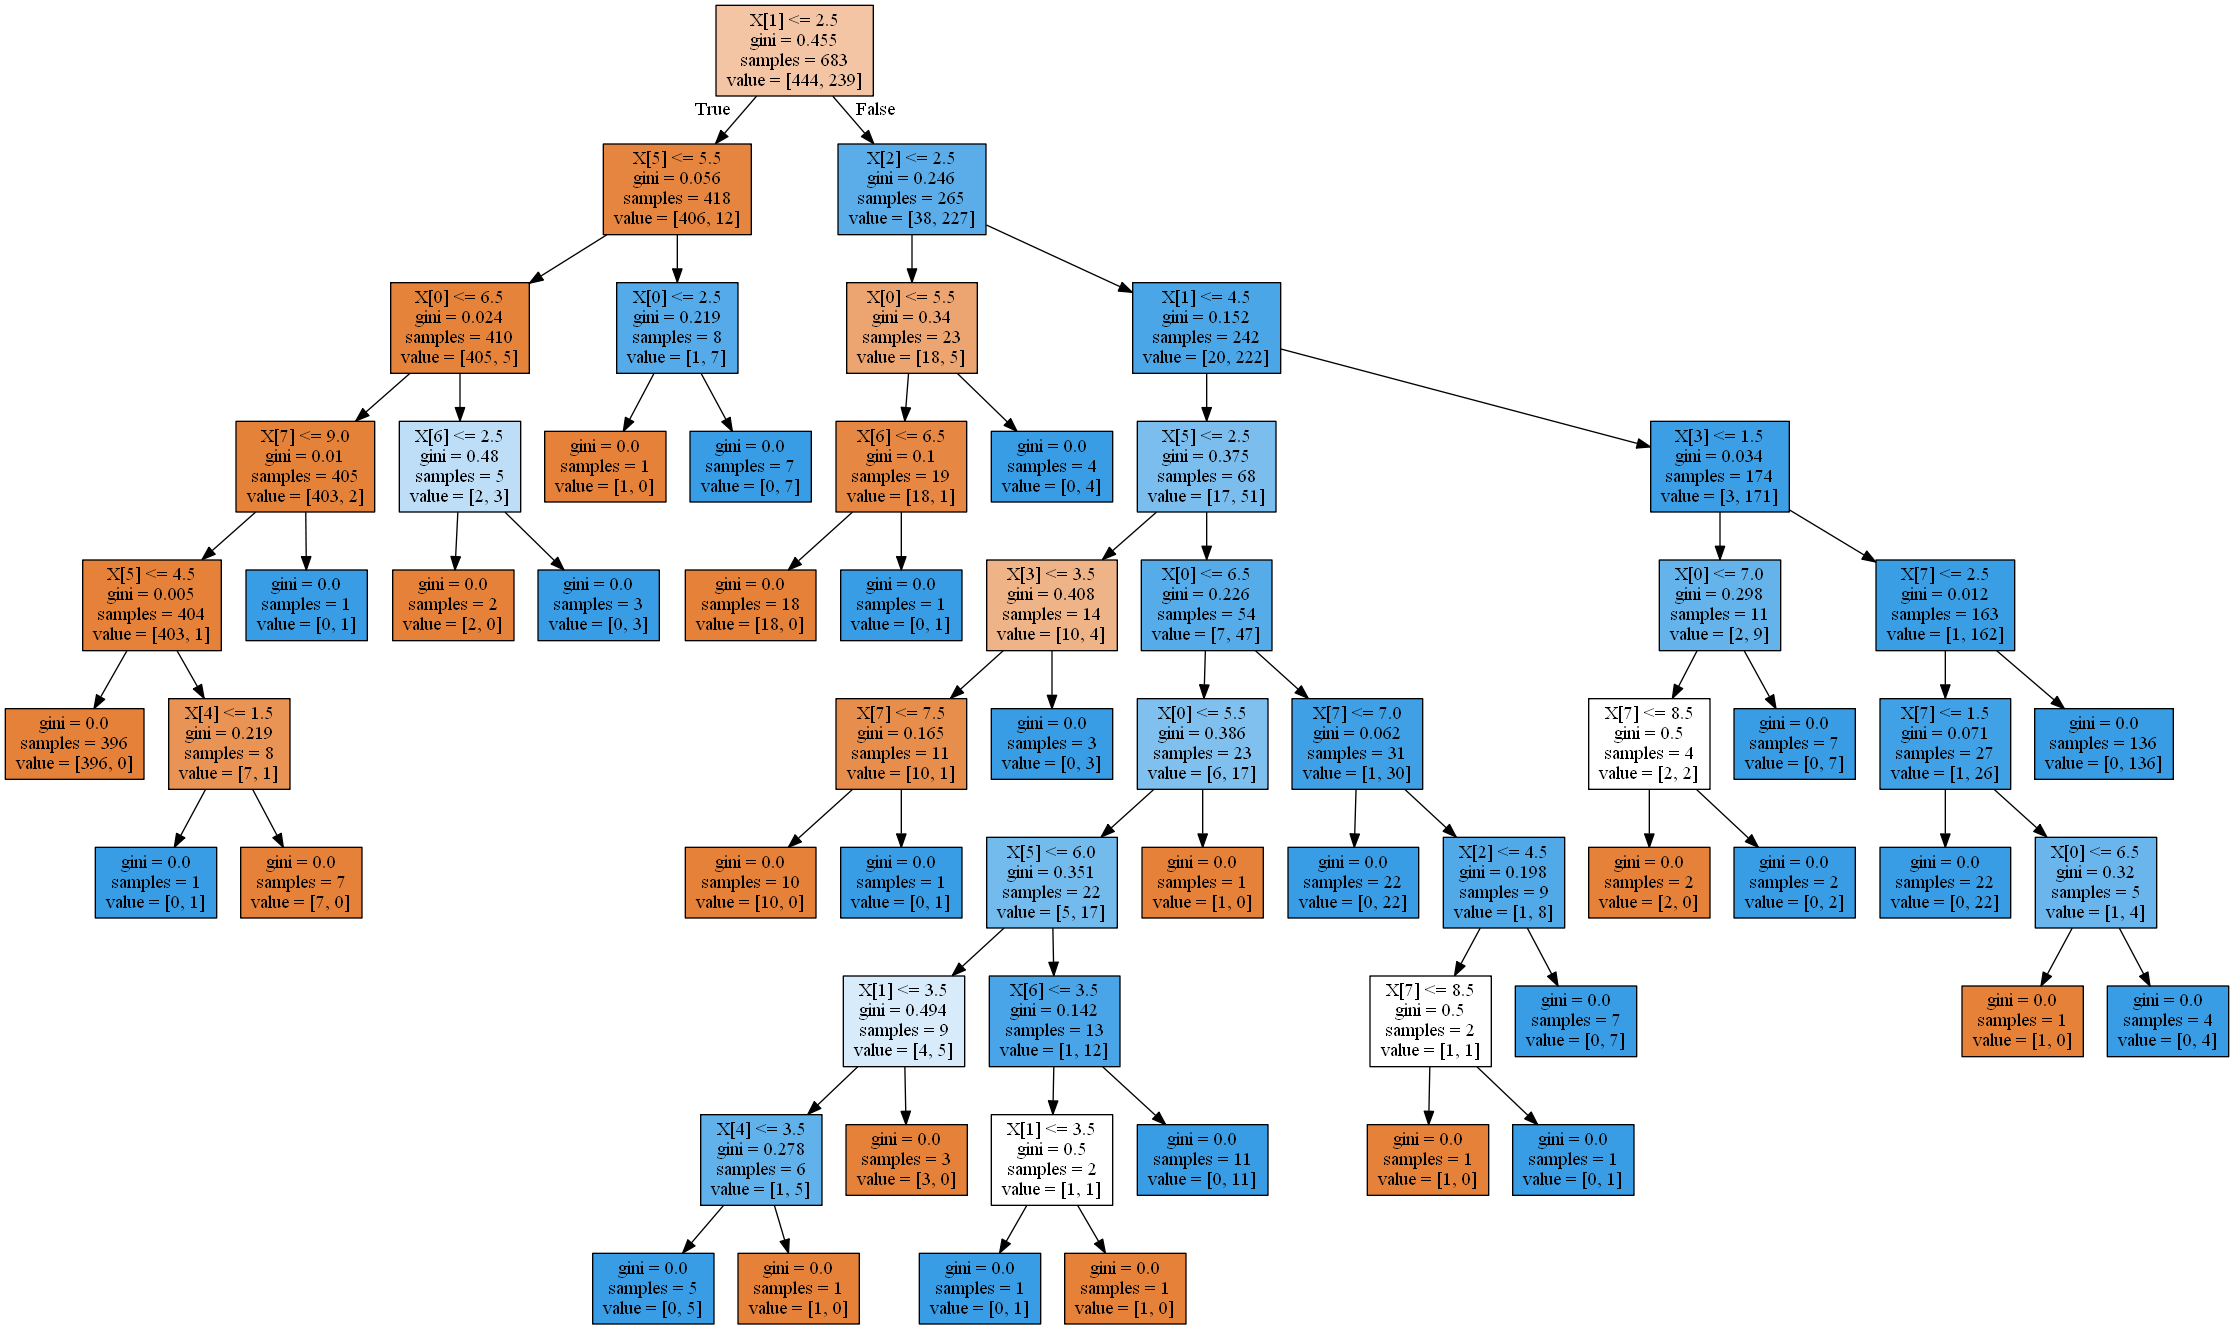

In [15]:
tree = DT_1.fit(BC_X, BC.CLASS)
draw_decision_tree(tree, node_ids = False)

## Manipulating hyperparameters of DT
- max_depth
- min_sample_split

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
np.random.seed(0)
hyperparamters = {'max_depth': list(range(2, 9)),  'min_samples_split': list(range(2, 30))} #hyperparameter를 dict type으로 넣기
GridCV = GridSearchCV(estimator=DT_1, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(BC_X, BC.CLASS)
GridCV.best_params_

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 980 out of 980 | elapsed:   11.1s finished


{'max_depth': 4, 'min_samples_split': 21}

In [18]:
DT_tuning = DecisionTreeClassifier(max_depth=4, min_samples_split = 21,  random_state=0)
np.random.seed(0)
scores_2 = cross_validate(DT_tuning, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score = False)

In [19]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]


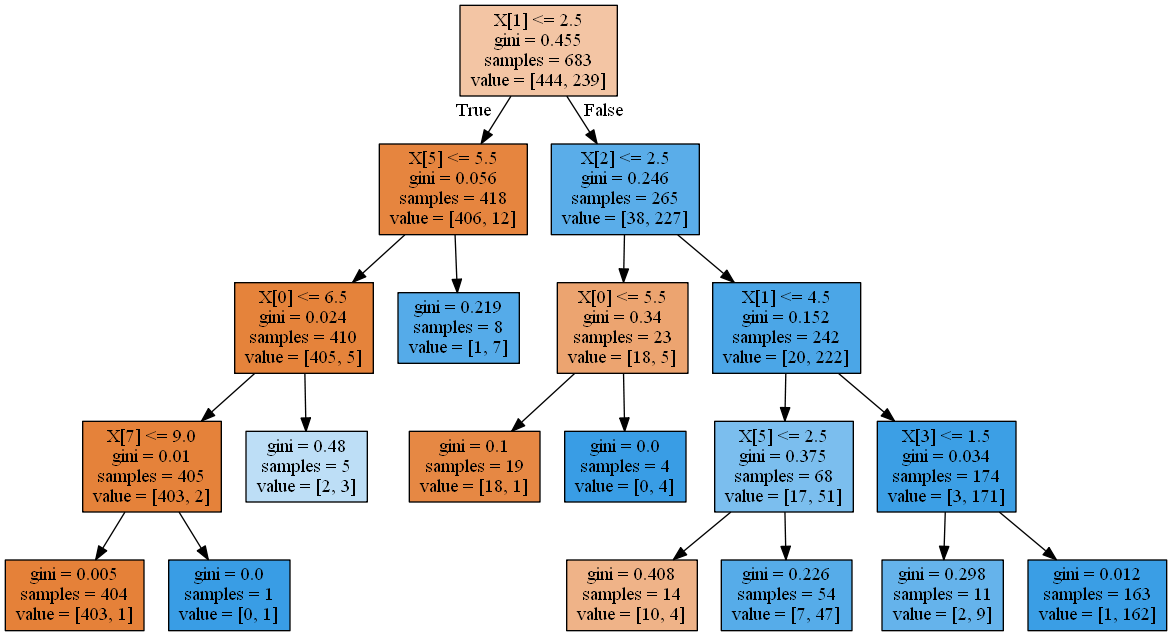

In [20]:
tree = DT_tuning.fit(BC_X, BC.CLASS)
draw_decision_tree(tree, node_ids = False)

***

## [Bagging](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-11-%EC%95%99%EC%83%81%EB%B8%94-%ED%95%99%EC%8A%B5-Ensemble-Learning-%EB%B0%B0%EA%B9%85Bagging%EA%B3%BC-%EB%B6%80%EC%8A%A4%ED%8C%85Boosting)

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
from sklearn.ensemble import BaggingClassifier

![bagging](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2Fb4wG8O%2FbtqyfYW98AS%2FYZBtUJy3jZLyuik1R0aGNk%2Fimg.png)

In [23]:
Ens_1 = BaggingClassifier(DT_1, oob_score=True, random_state=0)
np.random.seed(0)
scores_3=cross_validate(Ens_1,BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score=False)

In [24]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))
print('DT parameter tuning (X), Bagging tuning (X), F1 Score : [{:.3f}]'.format(np.mean(scores_3['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]
DT parameter tuning (X), Bagging tuning (X), F1 Score : [0.943]


***

In [25]:
Ens_2 = BaggingClassifier(DT_tuning, oob_score=True, random_state=0)
np.random.seed(0)
scores_4=cross_validate(Ens_2, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score=False)

In [26]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))
print('DT parameter tuning (X), Bagging tuning (X), F1 Score : [{:.3f}]'.format(np.mean(scores_3['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_4['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]
DT parameter tuning (X), Bagging tuning (X), F1 Score : [0.943]
DT parameter tuning (O), Bagging tuning (X), F1 Score : [0.938]


***

In [27]:
BaggingClassifier()

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

[sklearn.ensemble.BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- base_estimator : Decision Tree 등... 
- ★ n_estimators : bootstrap을 몇개할 것인가?
- ★ max_samples : train 데이터에서 샘플링할 비율
- max_feature : 변수를 몇개 사용할 것인가?
- [oob_score](https://daheekwon.github.io/bagging/) : Bagging 성능을 측정하기 위해 OOB 이용여부(OOB: 데이터셋에 포함 안 된 데이터로 성능 측정 여부)

In [28]:
np.random.seed(0)
hyperparamters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90],  'max_samples':[0.5, 0.6, 0.7, 0.8, 0.9, 1]}
GridCV = GridSearchCV(estimator=Ens_2, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(BC_X, BC.CLASS)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=4,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                            

In [29]:
GridCV.best_params_

{'max_samples': 0.5, 'n_estimators': 10}

In [30]:
Ens_2=BaggingClassifier(DT_tuning, max_samples=0.5, n_estimators=10,oob_score=True,random_state=0)

In [31]:
np.random.seed(0)
scores_5 = cross_validate(Ens_2, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score=False)

In [32]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))
print('DT parameter tuning (X), Bagging tuning (X), F1 Score : [{:.3f}]'.format(np.mean(scores_3['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_4['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_5['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]
DT parameter tuning (X), Bagging tuning (X), F1 Score : [0.943]
DT parameter tuning (O), Bagging tuning (X), F1 Score : [0.938]
DT parameter tuning (O), Bagging tuning (O), F1 Score : [0.948]


***

## [Random Forest]

In [33]:
from sklearn.ensemble import RandomForestClassifier

![rf](https://i.stack.imgur.com/sYR7y.png)

In [34]:
RF_1=RandomForestClassifier(random_state=0)

np.random.seed(0)
scores_6=cross_validate(RF_1, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score=False)

In [35]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))
print('DT parameter tuning (X), Bagging tuning (X), F1 Score : [{:.3f}]'.format(np.mean(scores_3['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_4['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_5['test_f1'])))
print("RF parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_6['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]
DT parameter tuning (X), Bagging tuning (X), F1 Score : [0.943]
DT parameter tuning (O), Bagging tuning (X), F1 Score : [0.938]
DT parameter tuning (O), Bagging tuning (O), F1 Score : [0.948]
RF parameter tuning (X), F1 Score : [0.950]


***

In [36]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

- max_depth : default=None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- ★ n_estimators : bagging과 동일, bootsrrap 갯수
- ★ <b>max_features</b> : 각 split할 때, 선택할 변수의 개수 
> 만약 'auto' 라면, max_features=sqrt(n_features)  
> 만약 'None' 이라면, max_features=n_features (변수개수 그 자체)  
> 직접 숫자를 넣어줄 수 있다.

In [37]:
np.random.seed(0)
hyperparamters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90], 'max_features':[1,2,3,4,5,6,7,8,9,10]}
GridCV = GridSearchCV(estimator=RF_1, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(BC_X, BC.CLASS)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   58.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [38]:
GridCV.best_params_

{'max_features': 1, 'n_estimators': 30}

In [39]:
np.random.seed(0)
RF_2 = RandomForestClassifier(n_estimators=30, max_features=1, random_state=0)
scores_7 = cross_validate(RF_2, BC_X, BC.CLASS, scoring=scoring, cv=5, return_train_score = False)

In [40]:
print("DT parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_1['test_f1'])))
print("DT parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_2['test_f1'])))
print('DT parameter tuning (X), Bagging tuning (X), F1 Score : [{:.3f}]'.format(np.mean(scores_3['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_4['test_f1'])))
print("DT parameter tuning (O), Bagging tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_5['test_f1'])))
print("RF parameter tuning (X), F1 Score : [{:.3f}]".format(np.mean(scores_6['test_f1'])))
print("RF parameter tuning (O), F1 Score : [{:.3f}]".format(np.mean(scores_7['test_f1'])))

DT parameter tuning (X), F1 Score : [0.909]
DT parameter tuning (O), F1 Score : [0.928]
DT parameter tuning (X), Bagging tuning (X), F1 Score : [0.943]
DT parameter tuning (O), Bagging tuning (X), F1 Score : [0.938]
DT parameter tuning (O), Bagging tuning (O), F1 Score : [0.948]
RF parameter tuning (X), F1 Score : [0.950]
RF parameter tuning (O), F1 Score : [0.956]


***

#### feature importance

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [41]:
import matplotlib.pyplot as plt

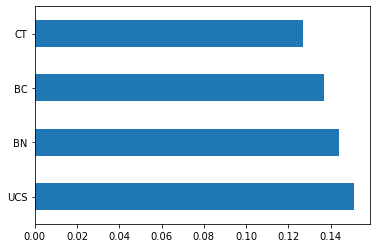

In [42]:
importances = RF_2.fit(BC_X, BC.CLASS).feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(RF_2.feature_importances_, index=BC.columns[1:-1])
feat_importances.nlargest(4).plot(kind='barh')
plt.show()